In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

4.14.3


### Data preparation

In [2]:
df = pd.read_csv(r'C:\Users\mi\MLcourse\mlcourse.ai\data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

### Predicting with FB Prophet

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


Question 1: What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

In [8]:
train_df = df[:-predictions].copy()

In [9]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2971.125440,1709.916324,2544.369834,2951.963062,2991.933893,-861.666255,-861.666255,-861.666255,-861.666255,-861.666255,-861.666255,0.0,0.0,0.0,2109.459185
379,2016-01-17,2976.423576,1847.196315,2664.453134,2956.075982,2998.215361,-720.685978,-720.685978,-720.685978,-720.685978,-720.685978,-720.685978,0.0,0.0,0.0,2255.737598
380,2016-01-18,2981.721713,2860.515408,3652.344184,2959.951846,3004.564545,281.426215,281.426215,281.426215,281.426215,281.426215,281.426215,0.0,0.0,0.0,3263.147928
381,2016-01-19,2987.019849,3077.861586,3915.369495,2963.842335,3010.908027,541.366440,541.366440,541.366440,541.366440,541.366440,541.366440,0.0,0.0,0.0,3528.386289
382,2016-01-20,2992.317986,3012.276255,3844.629291,2967.456694,3018.414802,425.464520,425.464520,425.464520,425.464520,425.464520,425.464520,0.0,0.0,0.0,3417.782506


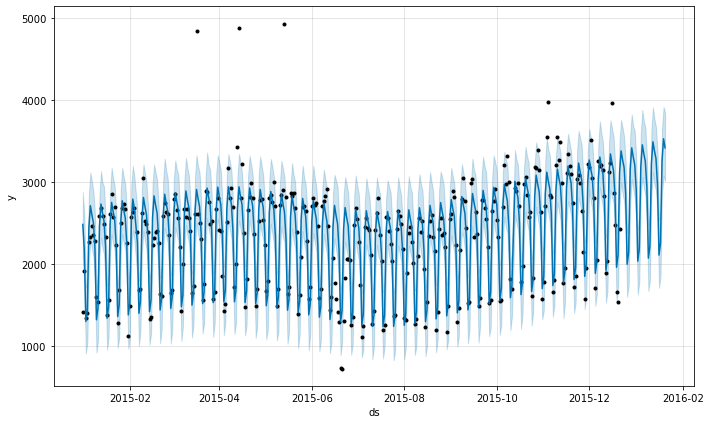

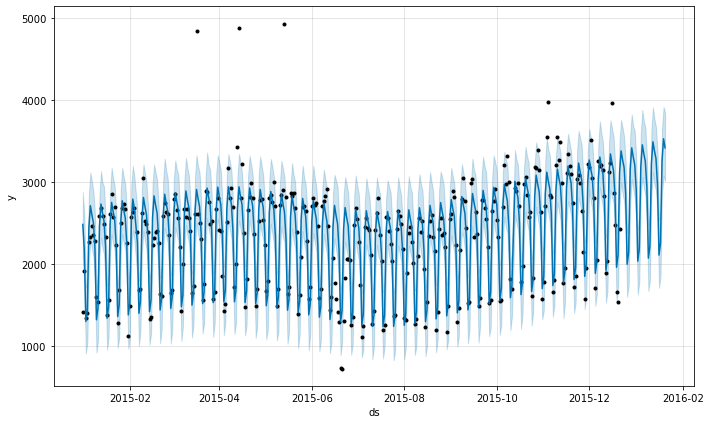

In [12]:
m.plot(forecast)

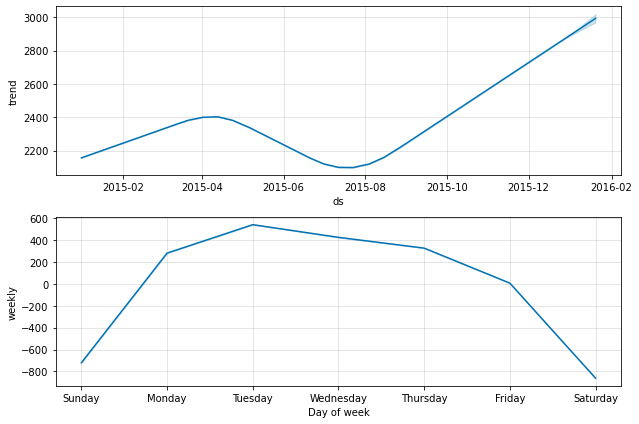

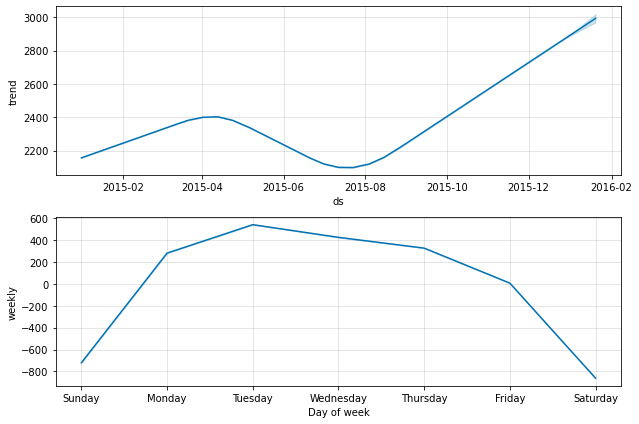

In [13]:
m.plot_components(forecast)

In [14]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

Question 2: What is MAPE equal to?

Question 3: What is MAE equal to?

In [15]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

MAPE =  34.19
MAE =  593.37


### Predicting with ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

Question 4: Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?

Dickey-Fuller test: p=0.107392


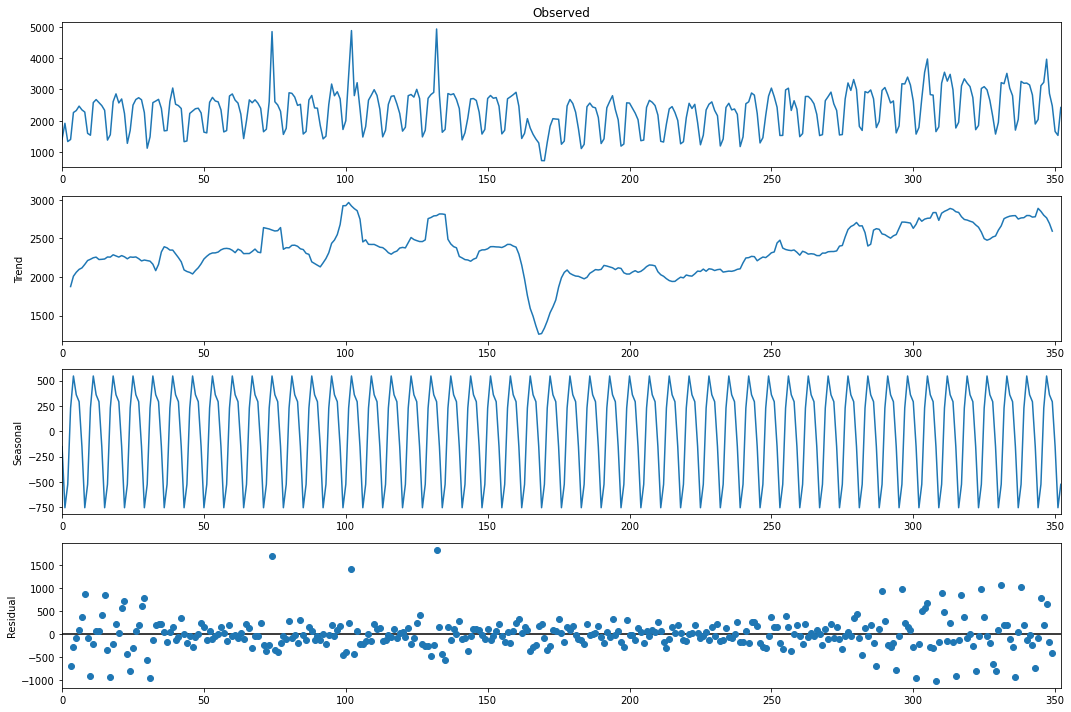

In [17]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [18]:
train_df.set_index('ds', inplace=True)

Dickey-Fuller test: p=0.000000


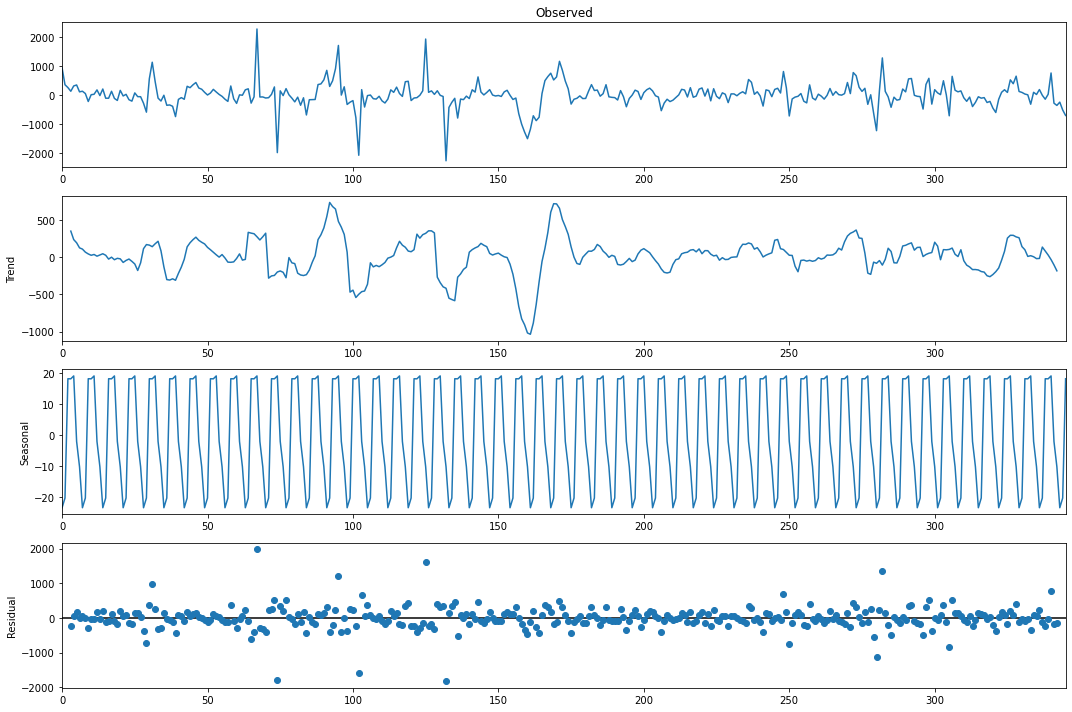

In [19]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

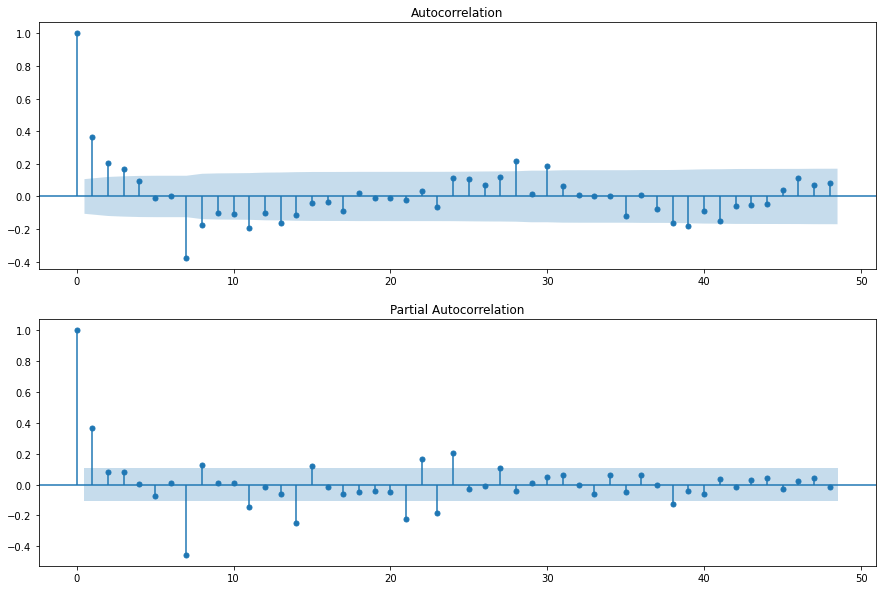

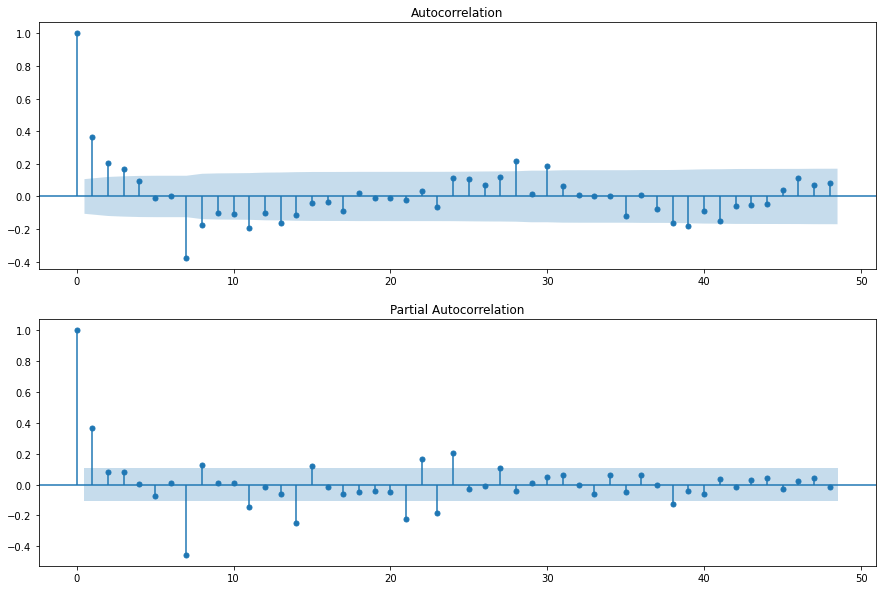

In [20]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [21]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [22]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [23]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [05:48<00:00,  1.10it/s]

Wall time: 5min 48s


In [24]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
352  (1, 1, 2, 2, 2, 1)    14.000000
66   (0, 0, 2, 3, 0, 1)    14.000000
232  (1, 0, 1, 2, 2, 1)   124.785219
346  (1, 1, 2, 1, 2, 1)   468.566239
90   (0, 0, 3, 3, 0, 1)  2762.692897


In [25]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
257,"(1, 0, 2, 3, 0, 0)",5183.825943
259,"(1, 0, 2, 3, 1, 0)",5022.312524
356,"(1, 1, 2, 3, 1, 1)",5019.555903
358,"(1, 1, 2, 3, 2, 1)",4989.002332


In [26]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [27]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 384/384 [05:21<00:00,  1.20it/s]


In [28]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
36   (0, 0, 1, 2, 0, 0)     8.000000
232  (1, 0, 1, 2, 2, 1)    12.000000
43   (0, 0, 1, 3, 0, 1)    12.000000
355  (1, 1, 2, 3, 2, 0)    14.000000
204  (1, 0, 0, 2, 0, 1)  1021.334881


C:\Programming\Anaconda\envs\BigData\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [29]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by='aic')

C:\Programming\Anaconda\envs\BigData\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,parameters,aic
356,"(1, 1, 2, 3, 2, 1)",3534.540192
258,"(1, 0, 2, 3, 1, 0)",3556.880030
354,"(1, 1, 2, 3, 1, 1)",3557.845351
256,"(1, 0, 2, 3, 0, 0)",3674.915914
